In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import os

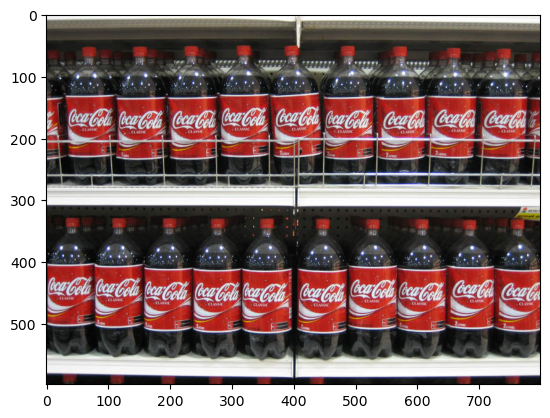

In [2]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)

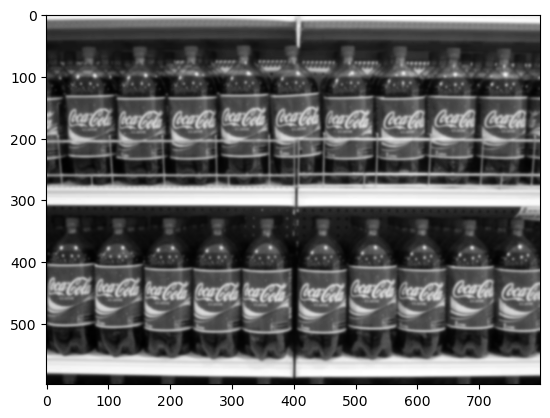

In [3]:
def preprocess(image):
    # recommendeded ratios for canny are: 2:1 and 3:1,
    value = 100
    ratio = 2 
    threshold_1, threshold_2 = value, value*ratio
    # if len(image.shape) == 3:
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    # grayscale = cv.equalizeHist(grayscale)
    blurred = cv.GaussianBlur(grayscale, (9, 9), 0)
    canny_edges = cv.Canny(grayscale, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred,threshold_1, threshold_2)
    return grayscale, blurred, canny_edges, canny_edges_after_blur

def preprocess_(image):
    return preprocess(image)[3]

grayscale, blurred, canny_edges, canny_edges_after_blur = preprocess(coca_multi)
plt.imshow(blurred, cmap='gray')

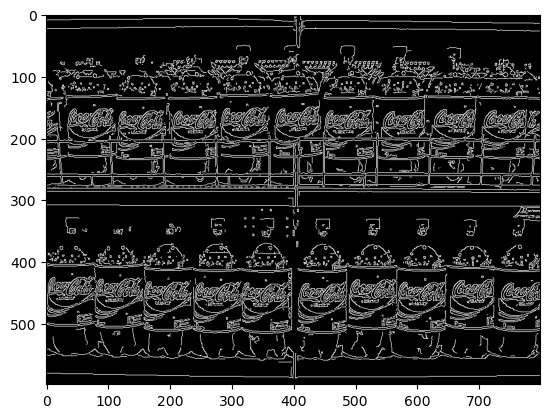

In [4]:
plt.imshow(canny_edges, cmap='gray')

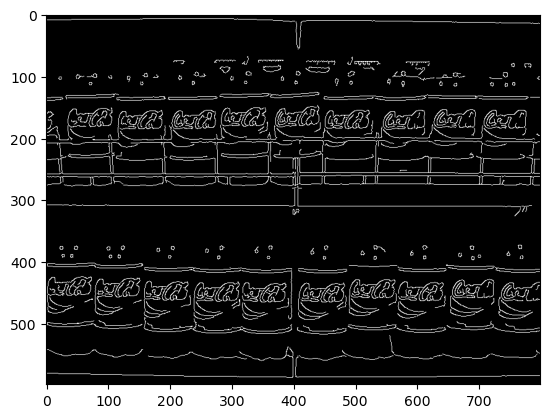

In [5]:
plt.imshow(canny_edges_after_blur, cmap='gray')

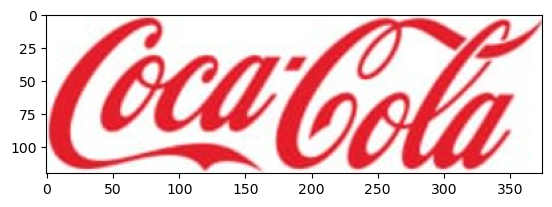

In [6]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
plt.imshow(template[30:-25, 10:-15])

(array([], dtype=int64), array([], dtype=int64))


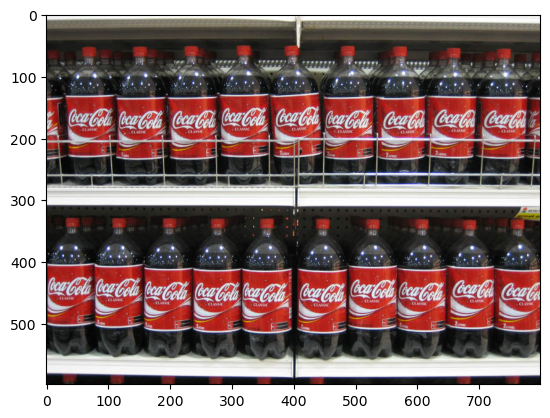

In [7]:
import numpy as np
res = cv.matchTemplate(preprocess_(coca_multi),preprocess_(template),cv.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
# print(len(loc))
modified = coca_multi.copy()
print(loc)
for pt in zip(*loc[::-1]):
    cv.rectangle(modified, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.imshow(modified)

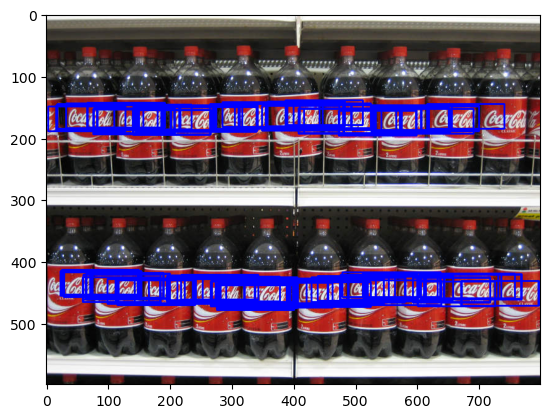

In [56]:
import imutils
def detect_logo(image_rgb, method):
    pre_template = preprocess_(template[30:-25, 10:-15])
    tW, tH = pre_template.shape[::-1]
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    # scales = np.linspace(0.5,2.0,20) 
    scales = [3]
    
    for scale in scales[::-1]:
        # print(f'iterating: {scale}')
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        if tH > resized.shape[0] or tW > resized.shape[1]:
            break

        # Detect edges in the resized, grayscale image and apply template matching
        edged = preprocess_(resized)
        result = cv.matchTemplate(edged, pre_template, method)
        normalized_result = cv.normalize(result, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

        threshold = 0.8
        loc = np.where( normalized_result >= threshold)
        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = int(top_left[0] * r), int(top_left[1] * r)
            endX, endY = int((top_left[0] + tW) * r), int((top_left[1] + tH) * r)
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)

    return modified_image

plt.imshow(detect_logo(coca_multi, cv.TM_CCOEFF ))

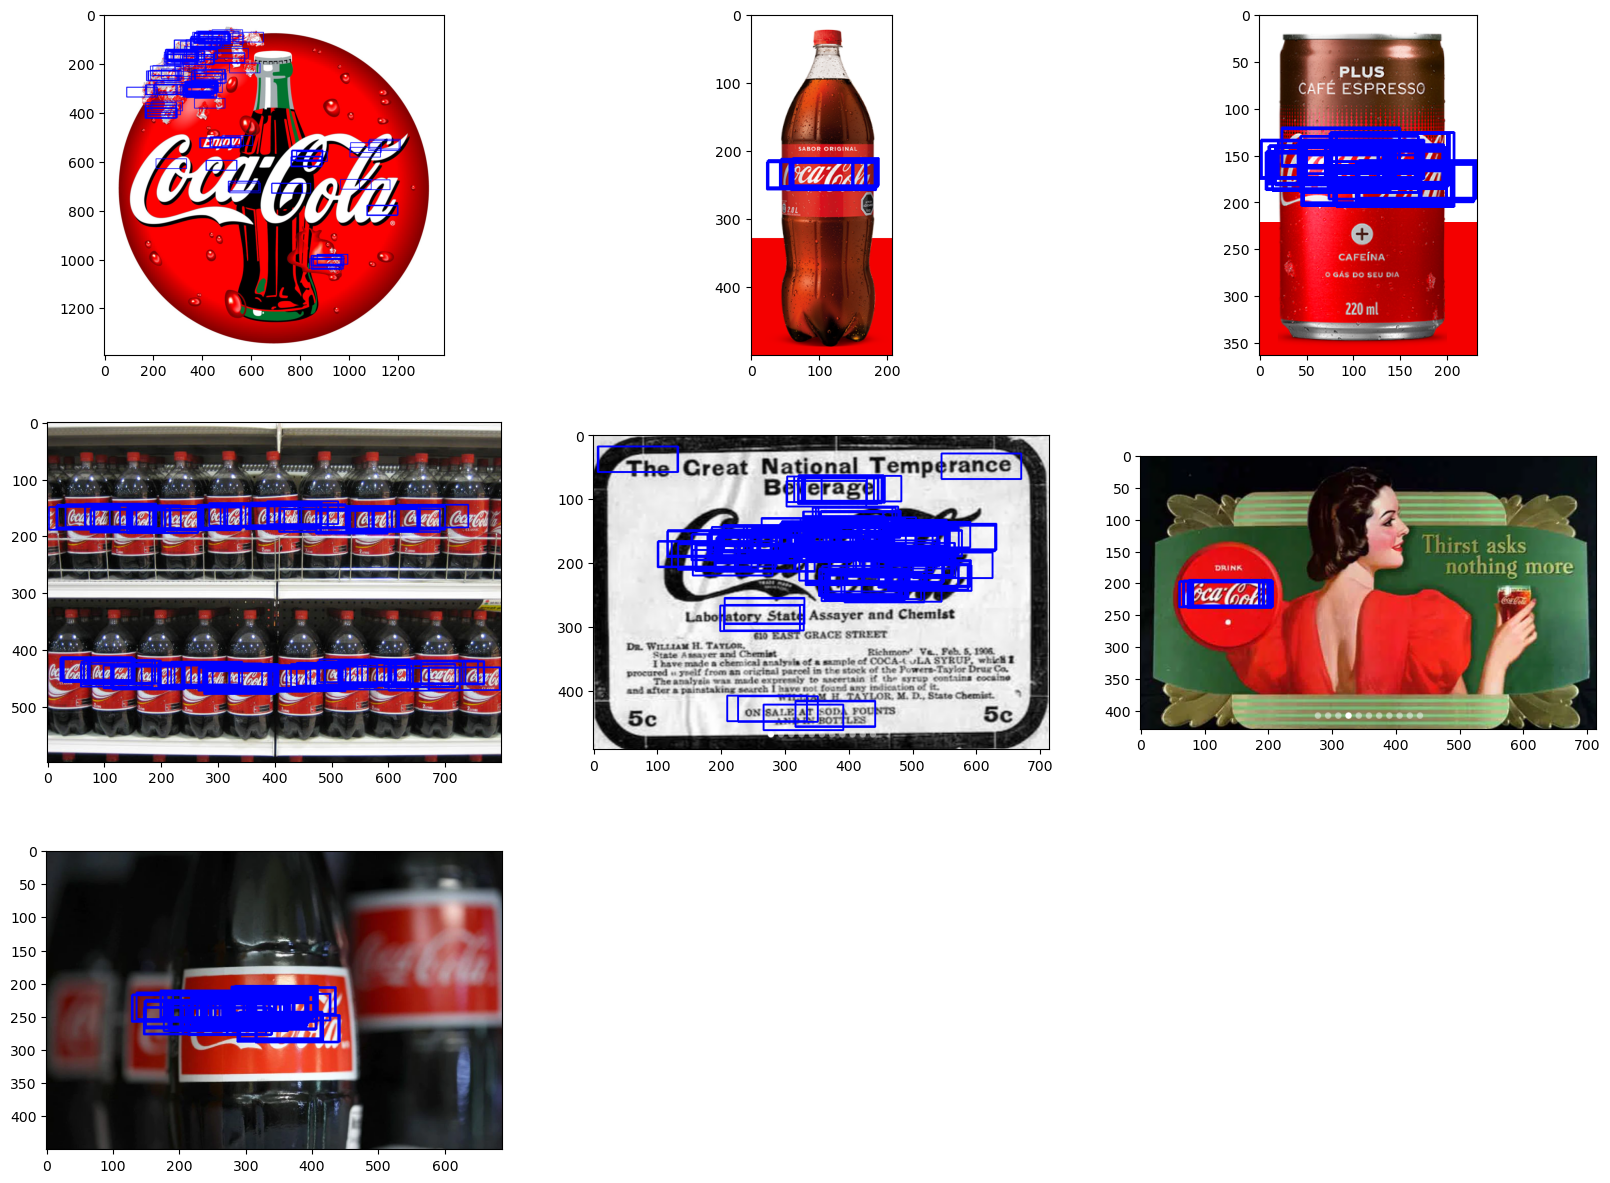

In [57]:
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

def plot_images(img_list, cols=3):
    rows = len(img_list)//cols + 1
    f, axes = plt.subplots(rows,cols, figsize=(20,15)) 
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        if i < len(img_list):
            ax.imshow(img_list[i])
        else:
            ax.axis('off')


detections = [detect_logo(image, cv.TM_CCOEFF) for image in test_images_color]
plot_images(detections)

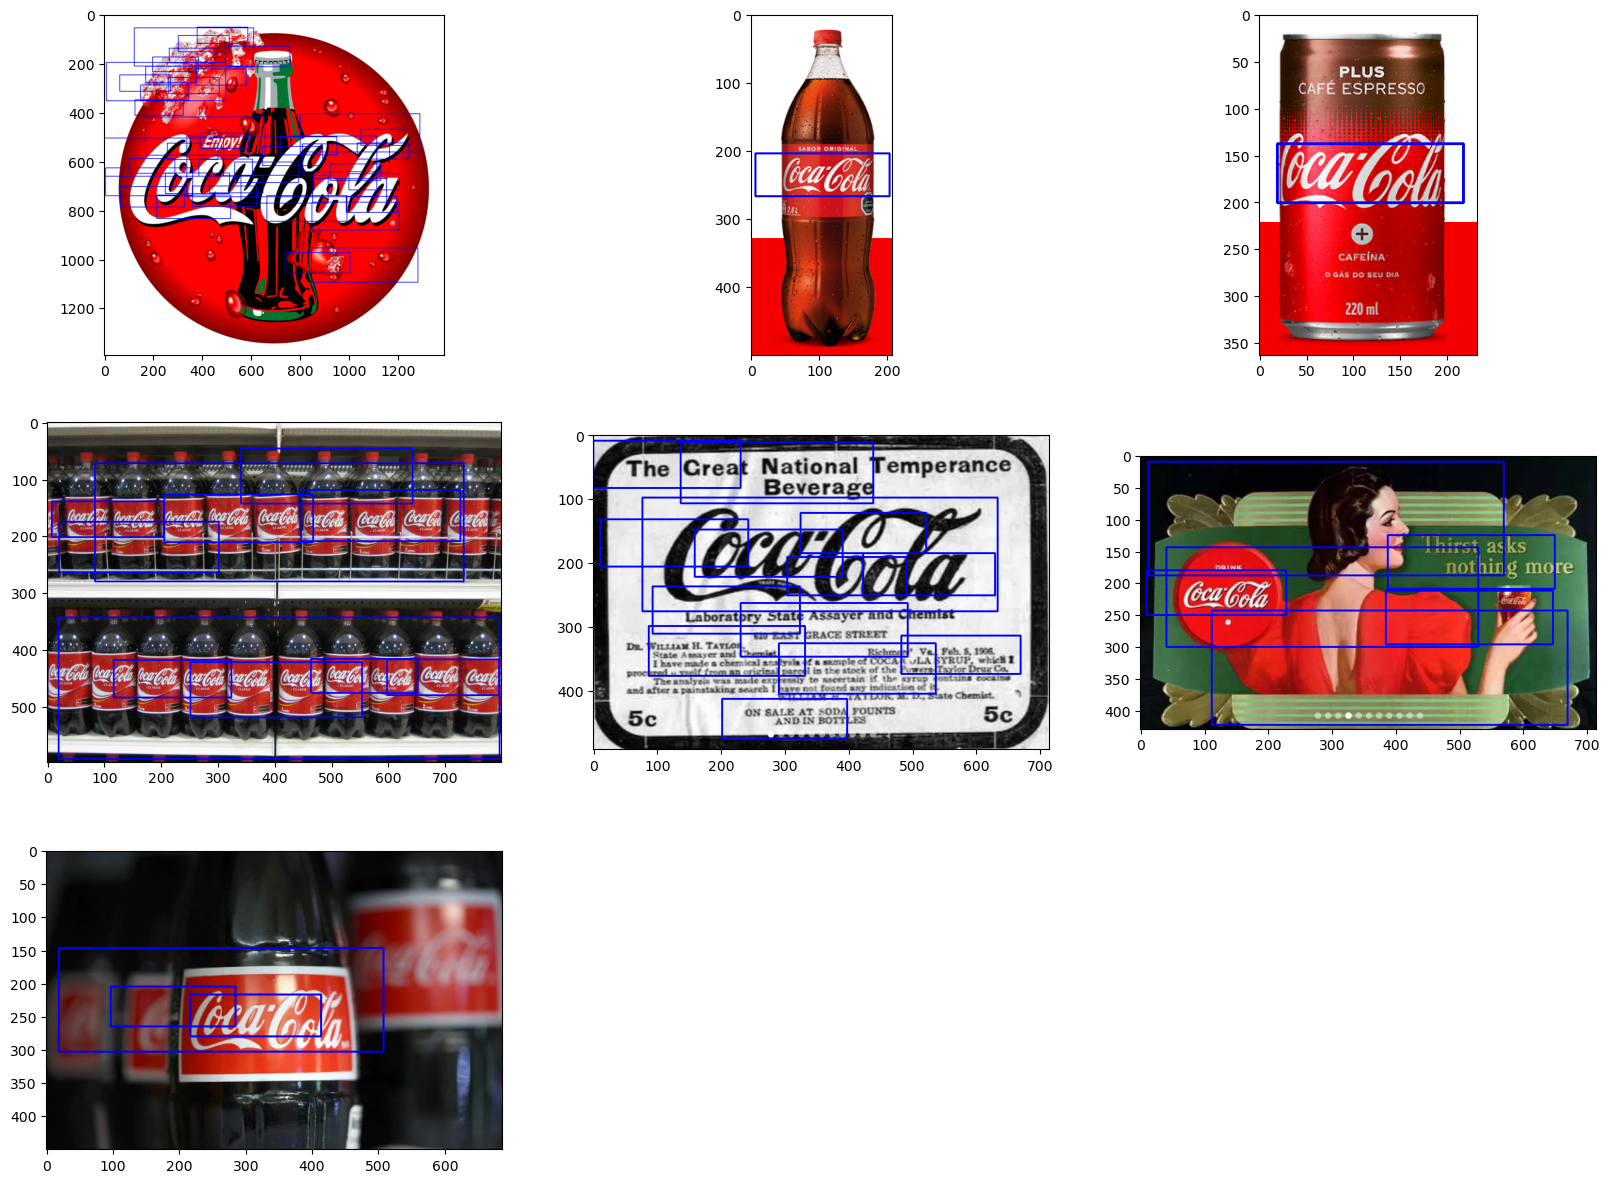

In [64]:
def detect_logo_with_nms(image_rgb, method):
    pre_template = preprocess_(template[30:-25, 10:-15])
    tW, tH = pre_template.shape[::-1]
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    scales = np.linspace(0.2, 2.0, 20)

    bounding_boxes = []
    confidences = []

    for scale in scales[::-1]:
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        if tH > resized.shape[0] or tW > resized.shape[1]:
            break

        edged = preprocess_(resized)
        result = cv.matchTemplate(edged, pre_template, method)
        normalized_result = cv.normalize(result, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

        threshold = 0.80
        loc = np.where(normalized_result >= threshold)
        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = int(top_left[0] * r), int(top_left[1] * r)
            endX, endY = int((top_left[0] + tW) * r), int((top_left[1] + tH) * r)
            bounding_boxes.append([startX, startY, endX - startX, endY - startY])
            confidences.append(float(normalized_result[pt[1], pt[0]]))


    bounding_boxes = np.array(bounding_boxes)
    confidences = np.array(confidences)

    indices = cv.dnn.NMSBoxes(bounding_boxes.tolist(), confidences.tolist(), score_threshold=0.8, nms_threshold=0.2)
    
    if len(indices) > 0:
        for i in indices.flatten():
            startX, startY, w, h = bounding_boxes[i]
            endX, endY = startX + w, startY + h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)

    return modified_image



detections = [detect_logo_with_nms(image, cv.TM_CCOEFF) for image in test_images_color]
plot_images(detections)

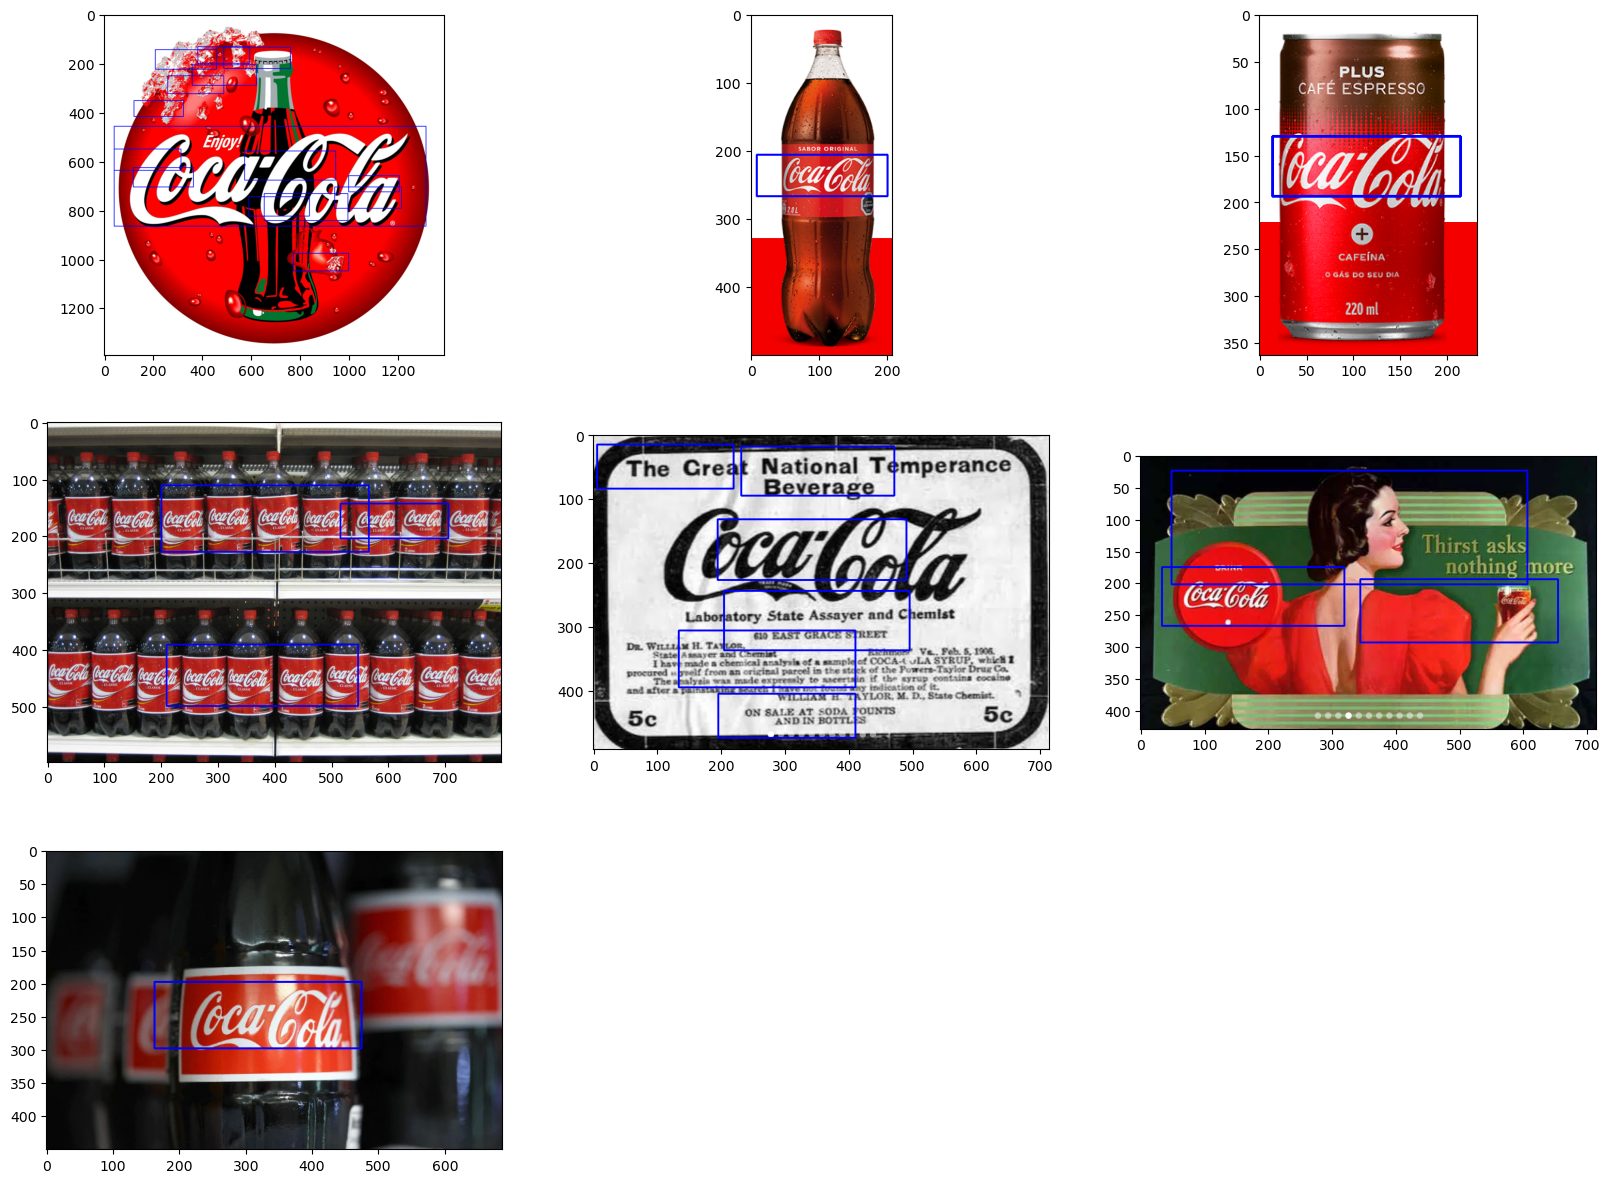

In [69]:
def detect_logo_with_grouping(image_rgb, method):
    pre_template = preprocess_(template[30:-25, 10:-15])
    tW, tH = pre_template.shape[::-1]
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    scales = np.linspace(0.2, 2.0, 20)
    

    rectangles = []

    for scale in scales[::-1]:
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        if tH > resized.shape[0] or tW > resized.shape[1]:
            break

        edged = preprocess_(resized)
        result = cv.matchTemplate(edged, pre_template, method)
        normalized_result = cv.normalize(result, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

        threshold = 0.8
        loc = np.where(normalized_result >= threshold)

        for pt in zip(*loc[::-1]):
            startX, startY = int(pt[0] * r), int(pt[1] * r)
            endX, endY = int((pt[0] + tW) * r), int((pt[1] + tH) * r)
            rectangles.append([startX, startY, endX - startX, endY - startY])  # [x, y, w, h]

    grouped_rectangles, _ = cv.groupRectangles(rectangles, groupThreshold=3, eps=0.2)

    for (x, y, w, h) in grouped_rectangles:
        cv.rectangle(modified_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    return modified_image


detections = [detect_logo_with_grouping(image, cv.TM_CCOEFF) for image in test_images_color]
plot_images(detections)